# Movie Recommendation System

In [1]:
pip install scikit-learn==1.6.1

Note: you may need to restart the kernel to use updated packages.


In [1]:
!pip install -U sentence-transformers


In [3]:
pip install scikit-surprise


  Using cached scikit_surprise-1.1.4.tar.gz (154 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp311-cp311-win_amd64.whl size=1298009 sha256=09195ebf80dda5aabc91021a4b9043ba8038a1cbe88a950eeca858b03d29ff9b
  Stored in directory: c:\users\haris\appdata\local\pip\cache\wheels\2a\8f\6e\7e2899163e2d85d8266daab4aa1cdabec7a6c56f83c015b5af
Successfully built scikit-surprise


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import requests
from concurrent.futures import ThreadPoolExecutor, as_completed
import time
import numpy as np
import pandas as pd
import asyncio
import aiohttp
from tqdm.notebook import tqdm
import nest_asyncio
import glob
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
from sklearn.neighbors import NearestNeighbors
import random
import joblib
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor, as_completed
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse


In [142]:
# Apply for notebook environments
nest_asyncio.apply()


In [143]:
API_KEY = "35c2764e71939361d5eb59cfe3197b52"

In [144]:
print(os.getcwd())

C:\Users\haris\OneDrive\Desktop\final_project_rec


In [145]:
dfl = pd.read_csv('links.csv')

In [146]:
dfm = pd.read_csv('movies.csv')

In [147]:
dfr = pd.read_csv('ratings.csv')

In [148]:
dft = pd.read_csv('tags.csv')

In [149]:
dfr.info()
dft.info()
dfl.info()
dfm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32000204 entries, 0 to 32000203
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 976.6 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000072 entries, 0 to 2000071
Data columns (total 4 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   userId     int64 
 1   movieId    int64 
 2   tag        object
 3   timestamp  int64 
dtypes: int64(3), object(1)
memory usage: 61.0+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87585 entries, 0 to 87584
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  87585 non-null  int64  
 1   imdbId   87585 non-null  int64  
 2   tmdbId   87461 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 2.0 MB
<class 'pandas.core.frame.DataFrame'>
Ran

In [150]:
# Merging all datasets using movieId as the anchor
df = dfl.merge(dfm, on='movieId', how='outer') \
               .merge(dfr, on='movieId', how='outer') \
               .merge(dft, on=['movieId', 'userId', 'timestamp'], how='outer')

In [151]:
df

,movieId,imdbId,tmdbId,title,genres,userId,rating,timestamp,tag
0,1,114709.0,862.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,10.0,2.5,1.169265e+09,NaN
1,1,114709.0,862.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,11.0,3.0,8.500851e+08,NaN
2,1,114709.0,862.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17.0,4.0,1.027306e+09,NaN
3,1,114709.0,862.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,19.0,3.0,9.747045e+08,NaN
4,1,114709.0,862.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,20.0,5.0,1.553184e+09,NaN
...,...,...,...,...,...,...,...,...,...
34003306,90645,NaN,NaN,NaN,NaN,162279.0,NaN,1.320818e+09,Rafe Spall
34003307,91079,NaN,NaN,NaN,NaN,162279.0,NaN,1.322337e+09,Anton Yelchin
34003308,91079,NaN,NaN,NaN,NaN,162279.0,NaN,1.322337e+09,Felicity Jones
34003309,91658,NaN,NaN,NaN,NaN,162279.0,NaN,1.325828e+09,Rooney Mara


In [152]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34003311 entries, 0 to 34003310
Data columns (total 9 columns):
 #   Column     Dtype  
---  ------     -----  
 0   movieId    int64  
 1   imdbId     float64
 2   tmdbId     float64
 3   title      object 
 4   genres     object 
 5   userId     float64
 6   rating     float64
 7   timestamp  float64
 8   tag        object 
dtypes: float64(5), int64(1), object(3)
memory usage: 2.3+ GB


In [153]:
missing_values = df.isnull().sum()
print(missing_values)

movieId             0
imdbId        1999518
tmdbId        2004246
title         1999518
genres        1999518
userId           3153
rating        2002671
timestamp        3153
tag          32003256
dtype: int64


In [154]:
# Removing rows with 3 or more missing values
df = df.dropna(thresh=df.shape[1] - 2)

In [155]:
missing_values2 = df.isnull().sum()
print(missing_values2)

movieId             0
imdbId              0
tmdbId           4726
title               0
genres              0
userId              0
rating              0
timestamp           0
tag          32000086
dtype: int64


In [156]:
df = df.drop(columns='tag')

In [157]:
df = df.dropna(subset=['tmdbId'])

In [158]:
df

,movieId,imdbId,tmdbId,title,genres,userId,rating,timestamp
0,1,114709.0,862.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,10.0,2.5,1.169265e+09
1,1,114709.0,862.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,11.0,3.0,8.500851e+08
2,1,114709.0,862.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17.0,4.0,1.027306e+09
3,1,114709.0,862.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,19.0,3.0,9.747045e+08
4,1,114709.0,862.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,20.0,5.0,1.553184e+09
...,...,...,...,...,...,...,...,...
32003788,292731,26812510.0,1032473.0,The Monroy Affaire (2022),Drama,50685.0,4.0,1.697075e+09
32003789,292737,14907358.0,986674.0,Shelter in Solitude (2023),Comedy|Drama,165364.0,1.5,1.697146e+09
32003790,292753,12388280.0,948139.0,Orca (2023),Drama,150812.0,4.0,1.697141e+09
32003791,292755,64027.0,182776.0,The Angry Breed (1968),Drama,91097.0,1.0,1.697145e+09


In [159]:
# Count how many times each userId appears
user_counts = df['userId'].value_counts()

top_10_most = user_counts.head(10)

top_10_least = user_counts.tail(10)

print("Top 10 users who rated the most:\n")
print(top_10_most)

print("\nTop 10 users who rated the least:\n")
print(top_10_least)


Top 10 users who rated the most:

userId
175325.0    33328
17035.0      9578
55653.0      9172
123465.0     9042
171795.0     9014
10202.0      7747
198515.0     7590
49305.0      7482
22744.0      7372
7858.0       7320
Name: count, dtype: int64

Top 10 users who rated the least:

userId
13863.0     20
162821.0    20
192201.0    19
51699.0     19
99999.0     19
191277.0    19
121187.0    19
160346.0    19
67751.0     19
104351.0    19
Name: count, dtype: int64


In [160]:
# Filtering movies with at least 20 ratings
movie_counts = df.groupby('movieId').size()
eligible_movies = movie_counts[movie_counts >= 20].index
df = df[df['movieId'].isin(eligible_movies)].copy()

In [161]:
# Filtering users who rated between 20 and 500 movies
user_counts = df['userId'].value_counts()
eligible_users = user_counts[(user_counts >= 20) & (user_counts <= 500)].index
df = df[df['userId'].isin(eligible_users)].copy()

In [162]:
# Keep only movies released after 1990
df = df[df['title'].str.extract(r'\((\d{4})\)').astype(float)[0] > 1990]

In [163]:
# Sample 5000 movies (after year and rating filters)
np.random.seed(42)
unique_movies = df['movieId'].unique()
if len(unique_movies) > 5000:
    sampled_movie_ids = np.random.choice(unique_movies, size=5000, replace=False)
else:
    sampled_movie_ids = unique_movies  # fallback if <10k remain
df = df[df['movieId'].isin(sampled_movie_ids)]

In [164]:
# Sample 50,000 users
unique_users = df['userId'].unique()
if len(unique_users) > 50000:
    sampled_user_ids = np.random.choice(unique_users, size=50000, replace=False)
else:
    sampled_user_ids = unique_users
df_sample = df[df['userId'].isin(sampled_user_ids)].copy()

In [165]:
print("Unique TMDB IDs in df_sample:", df_sample['tmdbId'].nunique())

Unique TMDB IDs in df_sample: 4702


In [166]:
# Save to CSV
file_path = "C:/Users/haris/OneDrive/Desktop/final_project_rec/df_sample.csv"
df_sample.to_csv(file_path, index=False)


file_path


'C:/Users/haris/OneDrive/Desktop/final_project_rec/df_sample.csv'

In [167]:
df_sample

,movieId,imdbId,tmdbId,title,genres,userId,rating,timestamp
5,1,114709.0,862.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,23.0,3.0,1.570190e+09
8,1,114709.0,862.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,33.0,5.0,1.226362e+09
13,1,114709.0,862.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,46.0,4.0,1.443951e+09
14,1,114709.0,862.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,51.0,3.5,1.151349e+09
24,1,114709.0,862.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,74.0,4.5,1.450133e+09
...,...,...,...,...,...,...,...,...
32002744,290407,14509110.0,820609.0,No One Will Save You (2023),Horror|Sci-Fi|Thriller,54463.0,2.5,1.695839e+09
32002766,290407,14509110.0,820609.0,No One Will Save You (2023),Horror|Sci-Fi|Thriller,124535.0,1.0,1.695890e+09
32002774,290407,14509110.0,820609.0,No One Will Save You (2023),Horror|Sci-Fi|Thriller,145918.0,1.5,1.696680e+09
32002785,290407,14509110.0,820609.0,No One Will Save You (2023),Horror|Sci-Fi|Thriller,197176.0,2.5,1.696829e+09


In [168]:
import pandas as pd

# Using regex to extract the year and remove it from the title in one go
df_sample['year'] = df_sample['title'].str.extract(r'\((\d{4})\)', expand=False)
df_sample['title'] = df_sample['title'].str.replace(r'\(\d{4}\)', '', regex=True).str.strip()

print(df_sample)


          movieId      imdbId    tmdbId                 title  \
5               1    114709.0     862.0             Toy Story   
8               1    114709.0     862.0             Toy Story   
13              1    114709.0     862.0             Toy Story   
14              1    114709.0     862.0             Toy Story   
24              1    114709.0     862.0             Toy Story   
...           ...         ...       ...                   ...   
32002744   290407  14509110.0  820609.0  No One Will Save You   
32002766   290407  14509110.0  820609.0  No One Will Save You   
32002774   290407  14509110.0  820609.0  No One Will Save You   
32002785   290407  14509110.0  820609.0  No One Will Save You   
32003011   290767  13444014.0  353577.0   Love at First Sight   

                                               genres    userId  rating  \
5         Adventure|Animation|Children|Comedy|Fantasy      23.0     3.0   
8         Adventure|Animation|Children|Comedy|Fantasy      33.0     5

In [169]:
import re

# Define a function to replace specified special characters with a space
def clean_title(title, remove_chars=None):
    if remove_chars is None:
        # Default: Remove all non-word characters (including punctuation)
        remove_chars = r'[^\w\s]'

    # Apply the regular expression to replace the specified characters
    title = re.sub(remove_chars, ' ', title)

    # Replace multiple spaces with a single space and strip leading/trailing spaces
    title = re.sub(r'\s+', ' ', title).strip()

    return title

characters_to_remove = r'[^\w\s]'

# Apply the function to the 'title' column, allowing the user to choose what to remove
df_sample['clean_title'] = df_sample['title'].apply(lambda x: clean_title(x, remove_chars=characters_to_remove))

print(df_sample)



          movieId      imdbId    tmdbId                 title  \
5               1    114709.0     862.0             Toy Story   
8               1    114709.0     862.0             Toy Story   
13              1    114709.0     862.0             Toy Story   
14              1    114709.0     862.0             Toy Story   
24              1    114709.0     862.0             Toy Story   
...           ...         ...       ...                   ...   
32002744   290407  14509110.0  820609.0  No One Will Save You   
32002766   290407  14509110.0  820609.0  No One Will Save You   
32002774   290407  14509110.0  820609.0  No One Will Save You   
32002785   290407  14509110.0  820609.0  No One Will Save You   
32003011   290767  13444014.0  353577.0   Love at First Sight   

                                               genres    userId  rating  \
5         Adventure|Animation|Children|Comedy|Fantasy      23.0     3.0   
8         Adventure|Animation|Children|Comedy|Fantasy      33.0     5

In [170]:
df_sample

,movieId,imdbId,tmdbId,title,genres,userId,rating,timestamp,year,clean_title
5,1,114709.0,862.0,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,23.0,3.0,1.570190e+09,1995,Toy Story
8,1,114709.0,862.0,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,33.0,5.0,1.226362e+09,1995,Toy Story
13,1,114709.0,862.0,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,46.0,4.0,1.443951e+09,1995,Toy Story
14,1,114709.0,862.0,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,51.0,3.5,1.151349e+09,1995,Toy Story
24,1,114709.0,862.0,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,74.0,4.5,1.450133e+09,1995,Toy Story
...,...,...,...,...,...,...,...,...,...,...
32002744,290407,14509110.0,820609.0,No One Will Save You,Horror|Sci-Fi|Thriller,54463.0,2.5,1.695839e+09,2023,No One Will Save You
32002766,290407,14509110.0,820609.0,No One Will Save You,Horror|Sci-Fi|Thriller,124535.0,1.0,1.695890e+09,2023,No One Will Save You
32002774,290407,14509110.0,820609.0,No One Will Save You,Horror|Sci-Fi|Thriller,145918.0,1.5,1.696680e+09,2023,No One Will Save You
32002785,290407,14509110.0,820609.0,No One Will Save You,Horror|Sci-Fi|Thriller,197176.0,2.5,1.696829e+09,2023,No One Will Save You


In [171]:
# Replacing the 'title' column with 'clean_title' (keeping the same position)
df_sample['title'] = df_sample['clean_title']

# Dropping 'clean_title' column as it's no longer needed
df_sample.drop(columns='clean_title', inplace=True)


In [172]:
df_sample

,movieId,imdbId,tmdbId,title,genres,userId,rating,timestamp,year
5,1,114709.0,862.0,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,23.0,3.0,1.570190e+09,1995
8,1,114709.0,862.0,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,33.0,5.0,1.226362e+09,1995
13,1,114709.0,862.0,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,46.0,4.0,1.443951e+09,1995
14,1,114709.0,862.0,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,51.0,3.5,1.151349e+09,1995
24,1,114709.0,862.0,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,74.0,4.5,1.450133e+09,1995
...,...,...,...,...,...,...,...,...,...
32002744,290407,14509110.0,820609.0,No One Will Save You,Horror|Sci-Fi|Thriller,54463.0,2.5,1.695839e+09,2023
32002766,290407,14509110.0,820609.0,No One Will Save You,Horror|Sci-Fi|Thriller,124535.0,1.0,1.695890e+09,2023
32002774,290407,14509110.0,820609.0,No One Will Save You,Horror|Sci-Fi|Thriller,145918.0,1.5,1.696680e+09,2023
32002785,290407,14509110.0,820609.0,No One Will Save You,Horror|Sci-Fi|Thriller,197176.0,2.5,1.696829e+09,2023


In [173]:
# Converting the timestamp column to datetime format
df_sample['timestamp'] = pd.to_datetime(df_sample['timestamp'], unit='s')
df_sample

,movieId,imdbId,tmdbId,title,genres,userId,rating,timestamp,year
5,1,114709.0,862.0,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,23.0,3.0,2019-10-04 11:52:12,1995
8,1,114709.0,862.0,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,33.0,5.0,2008-11-11 00:07:49,1995
13,1,114709.0,862.0,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,46.0,4.0,2015-10-04 09:36:55,1995
14,1,114709.0,862.0,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,51.0,3.5,2006-06-26 19:14:04,1995
24,1,114709.0,862.0,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,74.0,4.5,2015-12-14 22:40:23,1995
...,...,...,...,...,...,...,...,...,...
32002744,290407,14509110.0,820609.0,No One Will Save You,Horror|Sci-Fi|Thriller,54463.0,2.5,2023-09-27 18:24:33,2023
32002766,290407,14509110.0,820609.0,No One Will Save You,Horror|Sci-Fi|Thriller,124535.0,1.0,2023-09-28 08:40:34,2023
32002774,290407,14509110.0,820609.0,No One Will Save You,Horror|Sci-Fi|Thriller,145918.0,1.5,2023-10-07 12:00:09,2023
32002785,290407,14509110.0,820609.0,No One Will Save You,Horror|Sci-Fi|Thriller,197176.0,2.5,2023-10-09 05:31:34,2023


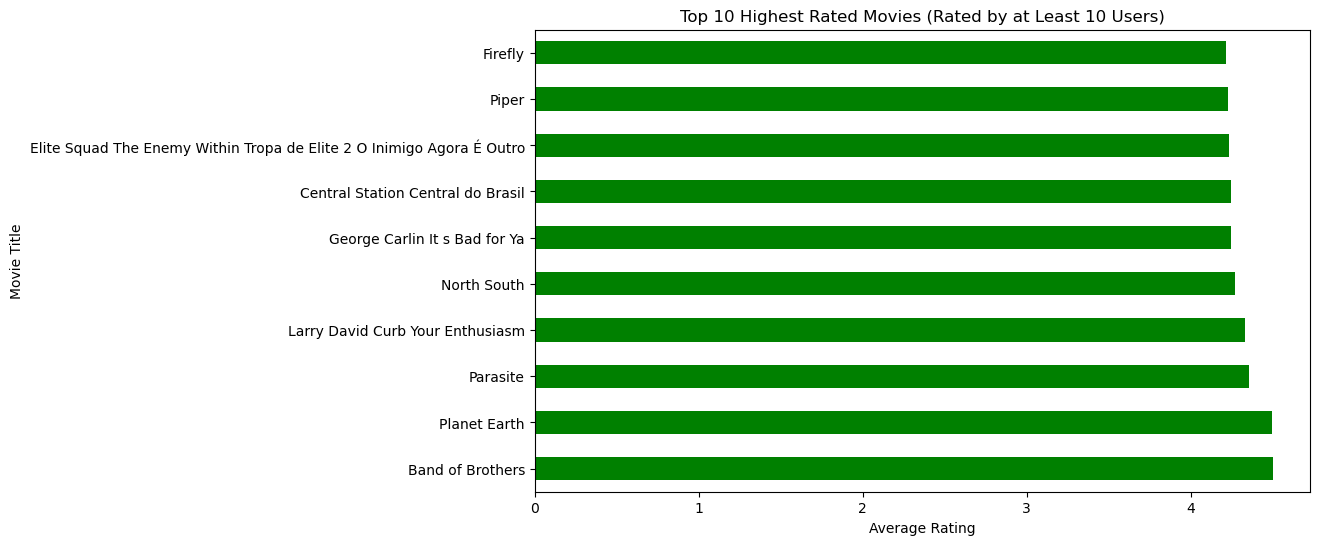

In [174]:
# Filtering movies rated by at least 10 users
movie_rating_counts = df_sample.groupby('title')['rating'].count()
movies_with_enough_ratings = movie_rating_counts[movie_rating_counts >= 50].index

# Filtering the original dataframe to only include those movies
filtered_df = df_sample[df_sample['title'].isin(movies_with_enough_ratings)]

# Calculate the top 10 highest rated movies
top_10_highest_rated = filtered_df.groupby('title')['rating'].mean().sort_values(ascending=False).head(10)

# Plotting the result
plt.figure(figsize=(10, 6))
top_10_highest_rated.plot(kind='barh', color='green')
plt.title('Top 10 Highest Rated Movies (Rated by at Least 10 Users)')
plt.xlabel('Average Rating')
plt.ylabel('Movie Title')
plt.show()


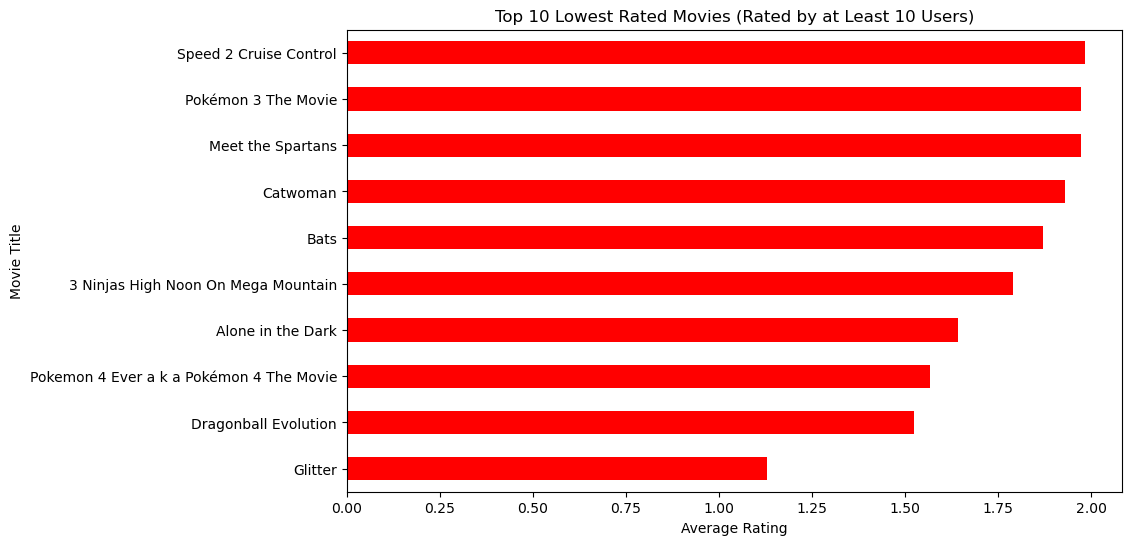

In [175]:
# Filter to only consider movies rated by at least 10 users
movie_rating_counts = df_sample.groupby('title')['rating'].count()
movies_with_enough_ratings = movie_rating_counts[movie_rating_counts >= 50].index

# Filtering the original dataframe to only include those movies
filtered_df = df_sample[df_sample['title'].isin(movies_with_enough_ratings)]

# Calculate the top 10 lowest rated movies
top_10_lowest_rated = filtered_df.groupby('title')['rating'].mean().sort_values().head(10)

# Plot the result
plt.figure(figsize=(10, 6))
top_10_lowest_rated.plot(kind='barh', color='red')
plt.title('Top 10 Lowest Rated Movies (Rated by at Least 10 Users)')
plt.xlabel('Average Rating')
plt.ylabel('Movie Title')
plt.show()


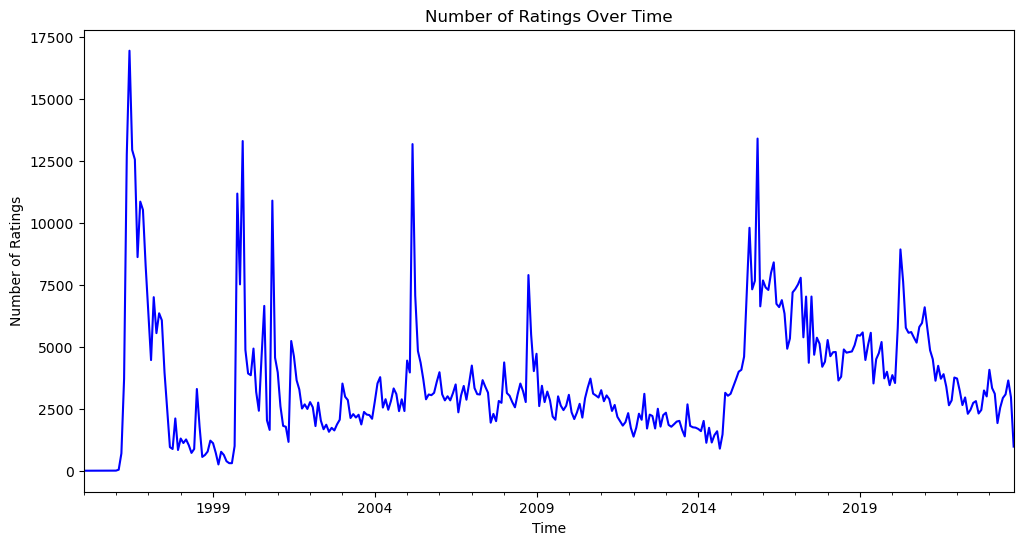

In [176]:
# The number of ratings over time using the timestamp column
df_sample['timestamp'] = pd.to_datetime(df_sample['timestamp'], unit='s')
df_sample['year_month'] = df_sample['timestamp'].dt.to_period('M')
ratings_over_time = df_sample.groupby('year_month')['rating'].count()

plt.figure(figsize=(12, 6))
ratings_over_time.plot(kind='line', color='blue')
plt.title('Number of Ratings Over Time')
plt.xlabel('Time')
plt.ylabel('Number of Ratings')
plt.show()


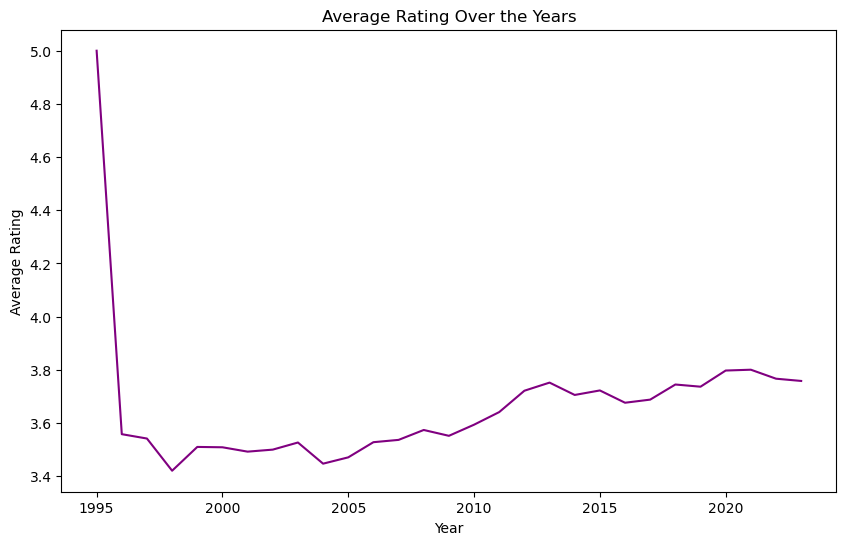

In [177]:
# Finding Average rating over the years using timestamp
df_sample['year'] = df_sample['timestamp'].dt.year
average_rating_by_year = df_sample.groupby('year')['rating'].mean()

plt.figure(figsize=(10, 6))
average_rating_by_year.plot(kind='line', color='purple')
plt.title('Average Rating Over the Years')
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.show()


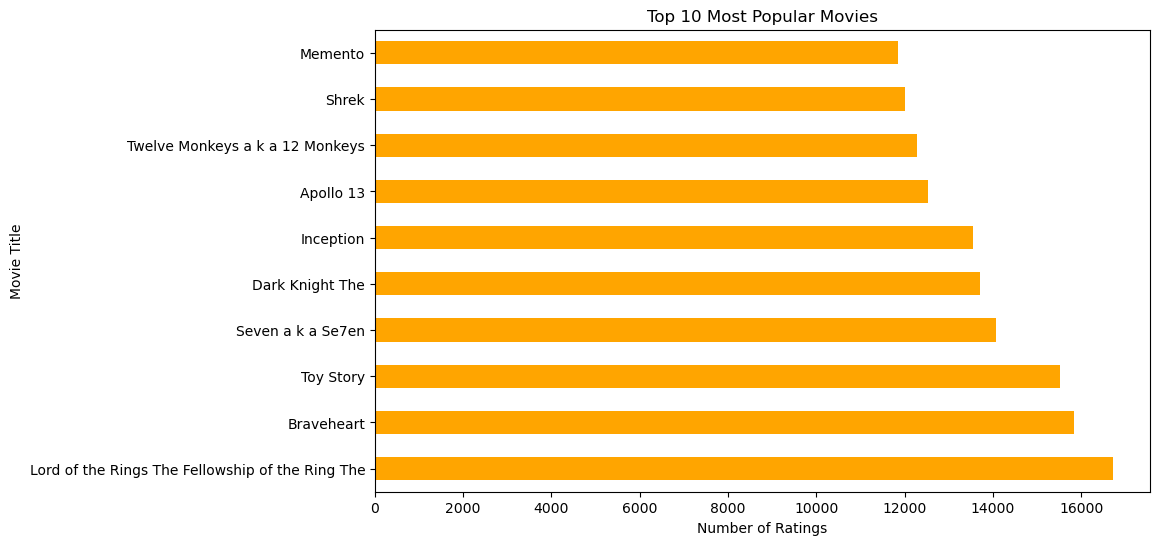

In [178]:
# Finding Top 10 most popular movies by number of ratings
top_10_most_popular_movies = df_sample.groupby('title')['rating'].count().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
top_10_most_popular_movies.plot(kind='barh', color='orange')
plt.title('Top 10 Most Popular Movies')
plt.xlabel('Number of Ratings')
plt.ylabel('Movie Title')
plt.show()


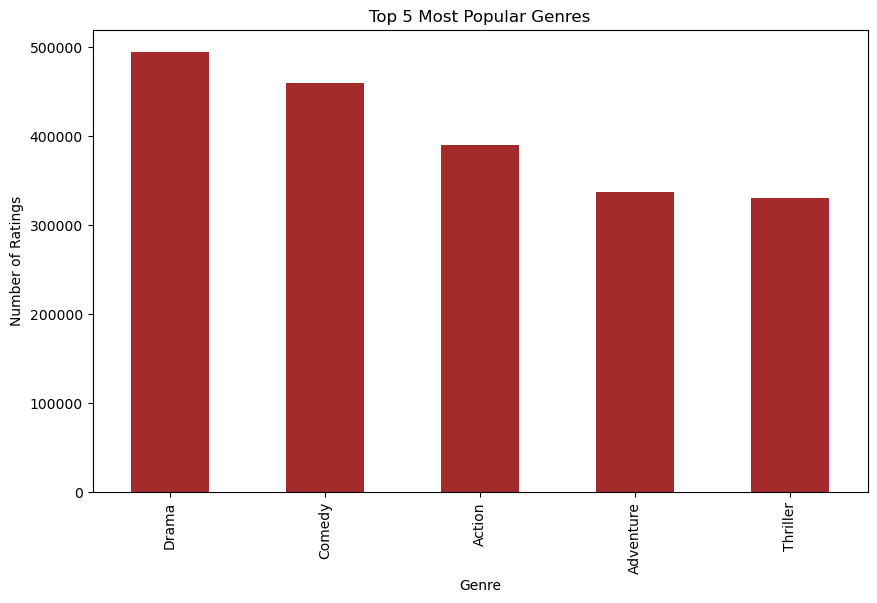

In [179]:
# Finding Top 5 most popular genres
df_sample['genres'] = df_sample['genres'].str.split('|')
genres_list = df_sample['genres'].explode().value_counts().head(5)

plt.figure(figsize=(10, 6))
genres_list.plot(kind='bar', color='brown')
plt.title('Top 5 Most Popular Genres')
plt.xlabel('Genre')
plt.ylabel('Number of Ratings')
plt.show()

In [180]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1235823 entries, 5 to 32003011
Data columns (total 10 columns):
 #   Column      Non-Null Count    Dtype         
---  ------      --------------    -----         
 0   movieId     1235823 non-null  int64         
 1   imdbId      1235823 non-null  float64       
 2   tmdbId      1235823 non-null  float64       
 3   title       1235823 non-null  object        
 4   genres      1235823 non-null  object        
 5   userId      1235823 non-null  float64       
 6   rating      1235823 non-null  float64       
 7   timestamp   1235823 non-null  datetime64[ns]
 8   year        1235823 non-null  int32         
 9   year_month  1235823 non-null  period[M]     
dtypes: datetime64[ns](1), float64(4), int32(1), int64(1), object(2), period[M](1)
memory usage: 99.0+ MB


In [181]:
num_unique_movies = df_sample['movieId'].nunique()
print("Number of unique movies:", num_unique_movies)

Number of unique movies: 4703


In [182]:
print(df_sample.columns)


Index(['movieId', 'imdbId', 'tmdbId', 'title', 'genres', 'userId', 'rating',
       'timestamp', 'year', 'year_month'],
      dtype='object')


In [183]:
# Set seed for reproducibility
np.random.seed(42)

# Drop NaNs and ensure tmdbId is integer
unique_movies = df_sample['tmdbId'].dropna().astype(int).unique()

# Sample 250 unique movies for test batch
sampled_movie_ids = np.random.choice(unique_movies, size=1000, replace=False)


In [184]:
# Save df_sampled_test for reference
df_sampled_test = df_sample[df_sample['tmdbId'].isin(sampled_movie_ids)]
df_sampled_test.to_csv("df_sampled_test.csv", index=False)


In [185]:
# Initialize processed IDs with the test sample
processed_ids = list(sampled_movie_ids)
pd.Series(processed_ids).to_csv("processed_ids.csv", index=False)

results = []


In [186]:
# Async fetcher function
def reset_results():
    global results
    results = []

async def fetch_movie_info(session, movie_id):
    credits_url = f"https://api.themoviedb.org/3/movie/{int(movie_id)}/credits?api_key={API_KEY}"
    details_url = f"https://api.themoviedb.org/3/movie/{int(movie_id)}?api_key={API_KEY}&append_to_response=releases"

    try:
        async with session.get(credits_url) as credits_response:
            if credits_response.status != 200:
                return movie_id, 'n/a', ['n/a']*3, 'n/a', 'n/a', None
            credits_data = await credits_response.json()

        async with session.get(details_url) as details_response:
            if details_response.status != 200:
                return movie_id, 'n/a', ['n/a']*3, 'n/a', 'n/a', None
            details_data = await details_response.json()

        director = next((p['name'] for p in credits_data.get("crew", []) if p.get("job") == "Director"), 'n/a')

        cast = credits_data.get("cast", [])
        top_actors = [actor.get("name", "n/a") for actor in cast[:3]]
        while len(top_actors) < 3:
            top_actors.append("n/a")

        description = details_data.get("overview", "n/a")

        rating = 'n/a'
        releases = details_data.get("releases", {}).get("countries", [])
        for country_info in releases:
            if country_info.get("iso_3166_1") == "US":
                rating = country_info.get("certification", "n/a")
                if rating:
                    break

        poster_path = details_data.get("poster_path")
        poster_url = f"https://image.tmdb.org/t/p/w500{poster_path}" if poster_path else None

        return movie_id, director, top_actors, rating, description, poster_url

    except Exception as e:
        print(f"Error fetching data for movie ID {movie_id}: {e}")
        return movie_id, 'n/a', ['n/a']*3, 'n/a', 'n/a', None



In [187]:
async def collect_movie_data(movie_ids):
    connector = aiohttp.TCPConnector(limit=40)
    timeout = aiohttp.ClientTimeout(total=60)
    async with aiohttp.ClientSession(connector=connector, timeout=timeout) as session:
        tasks = [fetch_movie_info(session, mid) for mid in movie_ids]
        for f in tqdm(asyncio.as_completed(tasks), total=len(tasks)):
            movie_id, director, actors, rating, desc, poster_url = await f
            results.append({
                "movie_id": movie_id,
                "director": director,
                "actor1": actors[0],
                "actor2": actors[1],
                "actor3": actors[2],
                "age_rating": rating if rating else "n/a",
                "description": desc,
                "poster_url": poster_url
            })


In [188]:
# Run initial batch of 1000 for testing
reset_results()
await collect_movie_data(sampled_movie_ids)
pd.DataFrame(results).to_csv("rec_info_df_batch1.csv", index=False)

# Loop over remaining IDs in 1000 batches
processed_ids = pd.read_csv("processed_ids.csv").squeeze("columns").tolist()
remaining_ids = [mid for mid in unique_movies if mid not in processed_ids]
batch_num = 2
batch_size = 2000

while remaining_ids:
    batch_ids = remaining_ids[:batch_size]
    remaining_ids = remaining_ids[batch_size:]

    reset_results()
    await collect_movie_data(batch_ids)

    pd.DataFrame(results).to_csv(f"rec_info_df_batch{batch_num}.csv", index=False)
    processed_ids.extend(batch_ids)
    pd.Series(processed_ids).to_csv("processed_ids.csv", index=False)

    batch_num += 1

100%|██████████| 1702/1702 [00:20<00:00, 81.42it/s] 


In [189]:
# Combining all batches
all_batches = glob.glob("rec_info_df_batch*.csv")
full_df = pd.concat([pd.read_csv(f) for f in all_batches], ignore_index=True)
full_df.to_csv("rec_info_full_dataset.csv", index=False)

In [190]:
# Keep rows with at least 2 non-NA values
extra_values = full_df.dropna(thresh=2)  


In [191]:
extra_values

,movie_id,director,actor1,actor2,actor3,age_rating,description,poster_url
12,101230,Theo van Gogh,Ariane Schluter,Ad van Kempen,NaN,NR,"Sarah, 30, single, well educated, likes art, p...",https://image.tmdb.org/t/p/w500/lSf3TgDjG7gPoA...
13,52274,Guillem Morales,Belén Rueda,Lluís Homar,Pablo Derqui,NR,"Julia, a woman suffering from a degenerative s...",https://image.tmdb.org/t/p/w500/p9HqHVdW9oedgR...
14,321741,Peter Landesman,Will Smith,Alec Baldwin,Albert Brooks,PG-13,A dramatic thriller based on the incredible tr...,https://image.tmdb.org/t/p/w500/1jEMpmmHEIO71t...
15,2045,John Dahl,Ray Liotta,Linda Fiorentino,Peter Coyote,R,Seattle medical examiner David Krane is obsess...,https://image.tmdb.org/t/p/w500/500Ne3EDn3HHpu...
16,134673,Gilles Bourdos,Michel Bouquet,Christa Théret,Vincent Rottiers,R,"In the French Riviera in the summer of 1915, J...",https://image.tmdb.org/t/p/w500/jmzC441vGgvPiZ...
...,...,...,...,...,...,...,...,...
4697,317560,Susan Johnson,Bel Powley,Vanessa Bayer,Colin O'Donoghue,NaN,"Awkward, isolated and disapproving of most of ...",https://image.tmdb.org/t/p/w500/IHuNvCTOsSox1G...
4698,210911,Juno Mak,Chin Siu-Ho,Anthony Chan Yau,Kara Wai Ying-Hung,NaN,When a former actor moves into an apartment bu...,https://image.tmdb.org/t/p/w500/hrdvYvPCf6KwNG...
4699,97989,Kleber Mendonça Filho,Irandhir Santos,Gustavo Jahn,Maeve Jinkings,NR,An independent private security firm arrives a...,https://image.tmdb.org/t/p/w500/gX5bvUtJZaBjWw...
4700,220289,James Ward Byrkit,Emily Baldoni,Maury Sterling,Nicholas Brendon,NR,Four couples gather for dinner the night a mys...,https://image.tmdb.org/t/p/w500/ezUtb9m5DeLwL2...


In [192]:
extra_values.to_csv("extra_values.csv", index=False)


In [45]:
extra_values = pd.read_csv('extra_values.csv')

In [46]:
extra_values = extra_values.rename( columns = {"rating": "age_rating"})

In [47]:
extra_values

,movie_id,director,actor1,actor2,actor3,age_rating,description,poster_url
0,101230,Theo van Gogh,Ariane Schluter,Ad van Kempen,NaN,NR,"Sarah, 30, single, well educated, likes art, p...",https://image.tmdb.org/t/p/w500/lSf3TgDjG7gPoA...
1,52274,Guillem Morales,Belén Rueda,Lluís Homar,Pablo Derqui,NR,"Julia, a woman suffering from a degenerative s...",https://image.tmdb.org/t/p/w500/p9HqHVdW9oedgR...
2,321741,Peter Landesman,Will Smith,Alec Baldwin,Albert Brooks,PG-13,A dramatic thriller based on the incredible tr...,https://image.tmdb.org/t/p/w500/1jEMpmmHEIO71t...
3,2045,John Dahl,Ray Liotta,Linda Fiorentino,Peter Coyote,R,Seattle medical examiner David Krane is obsess...,https://image.tmdb.org/t/p/w500/500Ne3EDn3HHpu...
4,134673,Gilles Bourdos,Michel Bouquet,Christa Théret,Vincent Rottiers,R,"In the French Riviera in the summer of 1915, J...",https://image.tmdb.org/t/p/w500/jmzC441vGgvPiZ...
...,...,...,...,...,...,...,...,...
4639,317560,Susan Johnson,Bel Powley,Vanessa Bayer,Colin O'Donoghue,NaN,"Awkward, isolated and disapproving of most of ...",https://image.tmdb.org/t/p/w500/IHuNvCTOsSox1G...
4640,210911,Juno Mak,Chin Siu-Ho,Anthony Chan Yau,Kara Wai Ying-Hung,NaN,When a former actor moves into an apartment bu...,https://image.tmdb.org/t/p/w500/hrdvYvPCf6KwNG...
4641,97989,Kleber Mendonça Filho,Irandhir Santos,Gustavo Jahn,Maeve Jinkings,NR,An independent private security firm arrives a...,https://image.tmdb.org/t/p/w500/gX5bvUtJZaBjWw...
4642,220289,James Ward Byrkit,Emily Baldoni,Maury Sterling,Nicholas Brendon,NR,Four couples gather for dinner the night a mys...,https://image.tmdb.org/t/p/w500/ezUtb9m5DeLwL2...


In [48]:
extra_values.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4644 entries, 0 to 4643
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   movie_id     4644 non-null   int64 
 1   director     4636 non-null   object
 2   actor1       4616 non-null   object
 3   actor2       4523 non-null   object
 4   actor3       4483 non-null   object
 5   age_rating   3290 non-null   object
 6   description  4641 non-null   object
 7   poster_url   4637 non-null   object
dtypes: int64(1), object(7)
memory usage: 290.4+ KB


In [49]:
df_sample = pd.read_csv('df_sample.csv')

In [50]:
# Merge datasets
df_sample = df_sample.rename(columns={"tmdbId": "movie_id"})
df_sample['movie_id'] = df_sample['movie_id'].astype('Int64')
merged_df = df_sample.merge(extra_values, on='movie_id', how='left')

# Fill NA in metadata
for col in ['description', 'director', 'actor1', 'actor2', 'actor3', 'age_rating']:
    merged_df[col] = merged_df[col].fillna('')

# Create movie_meta before using it
movie_meta = merged_df.groupby('movieId').first().reset_index()



# Build combined_features with new weights
movie_meta['combined_features'] = (
    ((movie_meta['genres'].str.replace('|', ' ') + " ") * 3) +        
    ((movie_meta['description'] + " ") * 4) +                         
    ((movie_meta['title'] + " ") * 1) +                                
    ((movie_meta['director'] + " ") * 2) +                             
    ((movie_meta['age_rating'] + " ") * 1)                             
)

# TF-IDF for content features
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movie_meta['combined_features'])


# Creating user-item matrix and center ratings for collaborative filtering
user_movie_ratings = df_sample.pivot_table(index='userId', columns='movieId', values='rating')
user_means = user_movie_ratings.mean(axis=1)
user_movie_ratings_centered = user_movie_ratings.sub(user_means, axis=0).fillna(0)

# Transpose for item-item CF 
item_movie_matrix = user_movie_ratings_centered.T  
knn = NearestNeighbors(metric='cosine', algorithm='brute')
knn.fit(item_movie_matrix.values)

import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors

# Helper to safely search for movie
def search_movie(title_input, movie_meta):
    title_input = title_input.lower()
    match = movie_meta[movie_meta['title'].str.lower().str.contains(title_input, regex=False)]
    return match['title'].iloc[0] if not match.empty else None

# Hybrid recommendation function
def hybrid_recommendations(title_input, movie_meta, tfidf_matrix, item_movie_matrix, user_movie_ratings, knn, alpha=0.6, penalty_weight=0.2, top_k=9):
    title = search_movie(title_input, movie_meta)
    if not title:
        return ["Movie title not found."]

    idx = movie_meta[movie_meta['title'] == title].index[0]
    movie_id = movie_meta.loc[idx, 'movieId']

    # Content-based similarity
    content_sim = cosine_similarity(tfidf_matrix[idx], tfidf_matrix).flatten()

    # Collaborative filtering similarity
    try:
        movie_idx_cf = user_movie_ratings.columns.get_loc(movie_id)
    except KeyError:
        return ["Not enough data for collaborative filtering."]

    movie_vector = item_movie_matrix.values[movie_idx_cf].reshape(1, -1)
    distances, indices_cf = knn.kneighbors(movie_vector, n_neighbors=11)  # include self

    cf_scores = np.zeros_like(content_sim)
    for i, cf_idx in enumerate(indices_cf.flatten()[1:]):  # skip self
        sim = 1 - distances.flatten()[i + 1]  # convert distance to similarity
        cf_scores[cf_idx] = sim

    # Normalize scores
    content_sim /= content_sim.max() if content_sim.max() != 0 else 1
    cf_scores /= cf_scores.max() if cf_scores.max() != 0 else 1

    # Hybrid blending
    hybrid_score = alpha * cf_scores + (1 - alpha) * content_sim

    # Penalize popularity
    if 'rating' in movie_meta.columns:
        popularity = movie_meta['rating'].fillna(0).values
        popularity = (popularity - popularity.min()) / (popularity.max() - popularity.min())
        hybrid_score -= penalty_weight * popularity

    # Exclude original movie
    hybrid_score[idx] = -1

    # Get top recommendations
    top_indices = hybrid_score.argsort()[::-1][:top_k]
    return movie_meta['title'].iloc[top_indices].tolist()




In [57]:
recs = hybrid_recommendations(
    title_input="toy story",
    movie_meta=movie_meta,
    tfidf_matrix=tfidf_matrix,
    item_movie_matrix=item_movie_matrix,
    user_movie_ratings=user_movie_ratings,
    knn=knn,
    alpha=0.6,
    penalty_weight=0.2,
    top_k=9
)
print("\nRecommended Movies:")
for i, rec in enumerate(recs, 1):
    print(f"{i}. {rec}")



Recommended Movies:
1. Monsters, Inc. (2001)
2. Finding Nemo (2003)
3. Beauty and the Beast (1991)
4. Babe (1995)
5. Shrek (2001)
6. Groundhog Day (1993)
7. Apollo 13 (1995)
8. Wallace & Gromit: The Wrong Trousers (1993)
9. Up (2009)


In [52]:
import os
import joblib
import pandas as pd
from scipy import sparse
from scipy.sparse import csr_matrix
# Creating output directory
os.makedirs("data", exist_ok=True)

movie_meta.to_csv("data/movie_meta.csv", index=False)

# Saving TF-IDF matrix as pickle
joblib.dump(tfidf_matrix, "data/tfidf_matrix.pkl")


# Convert item_movie_matrix (DataFrame) to a sparse matrix
item_movie_sparse = csr_matrix(item_movie_matrix.values)

# Save the sparse matrix using joblib
joblib.dump(item_movie_sparse, "data/item_movie_matrix.pkl")


# Saving k-NN model
joblib.dump(knn, "data/knn_model.pkl")

# Save user-movie ratings
joblib.dump(user_movie_ratings, "data/user_movie_ratings.pkl")

print("All files saved successfully in the 'data' folder.")


All files saved successfully in the 'data' folder.


In [53]:
movie_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4703 entries, 0 to 4702
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   movieId            4703 non-null   int64  
 1   imdbId             4703 non-null   float64
 2   movie_id           4703 non-null   Int64  
 3   title              4703 non-null   object 
 4   genres             4703 non-null   object 
 5   userId             4703 non-null   float64
 6   rating             4703 non-null   float64
 7   timestamp          4703 non-null   float64
 8   director           4703 non-null   object 
 9   actor1             4703 non-null   object 
 10  actor2             4703 non-null   object 
 11  actor3             4703 non-null   object 
 12  age_rating         4703 non-null   object 
 13  description        4703 non-null   object 
 14  poster_url         4638 non-null   object 
 15  combined_features  4703 non-null   object 
dtypes: Int64(1), float64(4),

In [54]:
def get_user_liked_movies(user_id, ratings_df, movie_meta, min_rating=4.0):
    """Returns a list of liked movie titles for a given user."""
    # Filter ratings by user and threshold
    liked_movies = ratings_df[
        (ratings_df['userId'] == user_id) & 
        (ratings_df['rating'] >= min_rating)
    ]['movieId']

    # Join with metadata to get titles
    liked_titles = movie_meta[movie_meta['movieId'].isin(liked_movies)]['title'].dropna().tolist()
    return liked_titles


In [55]:
from tqdm import tqdm
import numpy as np
import random
import pandas as pd

random.seed(42)
user_ids = random.sample(sorted(set(df_sample['userId'])), 5)  # small batch for faster inspection
top_k = 9
penalty_weight = 0.2
alpha_values = [round(a, 1) for a in np.arange(0.0, 1.1, 0.1)]

alpha_precision_results = []

for alpha in tqdm(alpha_values, desc="Alpha Grid Search"):
    print(f"\n--- Alpha: {alpha} ---")
    user_precisions = []

    for user_id in user_ids:
        liked = get_user_liked_movies(user_id, df_sample, movie_meta, min_rating=4.0)

        if not liked:
            print(f"User {user_id} has no liked movies")
            continue

        seed = random.choice(liked)
        print(f"\nUser {user_id} | Seed: {seed}")
        print(f"Liked: {liked}")

        try:
            recs = hybrid_recommendations(
                title_input=seed,
                movie_meta=movie_meta,
                tfidf_matrix=tfidf_matrix,
                item_movie_matrix=item_movie_matrix,
                user_movie_ratings=user_movie_ratings,
                knn=knn,
                alpha=alpha,
                penalty_weight=penalty_weight,
                top_k=top_k
            )
            print(f"Recs: {recs}")

            overlap = set(recs) & set(liked)
            print(f"Overlap: {overlap}")

            precision = precision_at_k(recs, liked, k=top_k)
            print(f"Precision@{top_k}: {precision:.3f}")
            user_precisions.append(precision)

        except Exception as e:
            print(f"Error for user {user_id}, seed '{seed}': {e}")
            continue

    avg_precision = np.mean(user_precisions) if user_precisions else 0.0
    print(f"Average precision at alpha {alpha}: {avg_precision:.3f}")
    alpha_precision_results.append((alpha, avg_precision))

# Output final result
alpha_results_df = pd.DataFrame(alpha_precision_results, columns=["alpha", "avg_precision@9"])



Alpha Grid Search:   0%|          | 0/11 [00:00<?, ?it/s]


--- Alpha: 0.0 ---

User 168285.0 | Seed: Kill Bill: Vol. 1 (2003)
Liked: ['Lord of the Rings: The Fellowship of the Ring, The (2001)', 'Kill Bill: Vol. 1 (2003)', 'Inception (2010)', 'The Martian (2015)']
Recs: ['Street Fighter: The Legend of Chun-Li (2009)', 'Emperor and the Assassin, The (Jing ke ci qin wang) (1999)', 'Master Gardener (2023)', 'Terrorist, The (a.k.a. Malli) (Theeviravaathi) (1998)', 'Dilwale (2015)', 'Coffee & Kareem (2020)', 'Mutant Action (Acción Mutante) (1993)', 'Azumi (2003)', 'Cry of the Owl, The (2009)']
Overlap: set()
Precision@9: 0.000

User 29171.0 | Seed: Iron Man (2008)
Liked: ['Braveheart (1995)', 'Trainspotting (1996)', 'Lock, Stock & Two Smoking Barrels (1998)', 'Snatch (2000)', 'Lord of the Rings: The Fellowship of the Ring, The (2001)', 'Red Dragon (2002)', 'Equilibrium (2002)', 'Man on Fire (2004)', 'Batman Begins (2005)', 'Island, The (2005)', 'Lucky Number Slevin (2006)', 'X-Men: The Last Stand (2006)', 'Pursuit of Happyness, The (2006)', 'Trans

Alpha Grid Search:   9%|▉         | 1/11 [00:05<00:56,  5.62s/it]

Recs: ['Senior Year (2022)', 'Date and Switch (2014)', 'Premature (2014)', 'Project X (2012)', 'Final Destination 3 (2006)', 'Sex Drive (2008)', "There's Something About Mary (1998)", 'Luokkakokous (2015)', 'Zombeavers (2014)']
Overlap: set()
Precision@9: 0.000
Average precision at alpha 0.0: 0.000

--- Alpha: 0.1 ---

User 168285.0 | Seed: Lord of the Rings: The Fellowship of the Ring, The (2001)
Liked: ['Lord of the Rings: The Fellowship of the Ring, The (2001)', 'Kill Bill: Vol. 1 (2003)', 'Inception (2010)', 'The Martian (2015)']
Recs: ['Tom and Jerry: The Magic Ring (2002)', 'Kickboxer 2: The Road Back (1991)', 'Vampire Effect (The Twins Effect) (Chin gei bin) (2003)', 'Open Season 3 (2010)', 'Big Ass Spider! (2013)', 'Patema Inverted (2013)', 'Foodfight! (2012)', 'Feel the Beat (2020)', 'Faces of Death: Fact or Fiction? (1999)']
Overlap: set()
Precision@9: 0.000

User 29171.0 | Seed: Big Short, The (2015)
Liked: ['Braveheart (1995)', 'Trainspotting (1996)', 'Lock, Stock & Two Smo

Alpha Grid Search:  18%|█▊        | 2/11 [00:10<00:47,  5.31s/it]

Recs: ['Pocahontas (1995)', 'Backwoods (Bosque de sombras) (2006)', 'In the Cut (2003)', 'After the Rain (Ame agaru) (1999) ', 'Charlotte Gray (2001)', 'Jimmy O. Yang: Good Deal (2020)', 'Few Good Men, A (1992)', 'Dilwale (2015)', 'Rebirth (2016)']
Overlap: set()
Precision@9: 0.000
Average precision at alpha 0.1: 0.000

--- Alpha: 0.2 ---

User 168285.0 | Seed: Lord of the Rings: The Fellowship of the Ring, The (2001)
Liked: ['Lord of the Rings: The Fellowship of the Ring, The (2001)', 'Kill Bill: Vol. 1 (2003)', 'Inception (2010)', 'The Martian (2015)']
Recs: ['Tom and Jerry: The Magic Ring (2002)', 'Kickboxer 2: The Road Back (1991)', 'Vampire Effect (The Twins Effect) (Chin gei bin) (2003)', 'Dark Knight, The (2008)', 'Open Season 3 (2010)', 'Big Ass Spider! (2013)', 'Patema Inverted (2013)', 'Foodfight! (2012)', 'Pirates of the Caribbean: The Curse of the Black Pearl (2003)']
Overlap: set()
Precision@9: 0.000

User 29171.0 | Seed: Transformers (2007)
Liked: ['Braveheart (1995)', 'T

Alpha Grid Search:  27%|██▋       | 3/11 [00:16<00:44,  5.55s/it]

Recs: ['Pork Pie (2017)', 'Scary Movie 3 (2003)', 'Breaking News (Daai si gin) (2004)', "Tyler Perry's Why Did I Get Married? (2007)", 'Instinct (1999)', 'Kissing a Fool (1998)', "General's Daughter, The (1999)", 'Srimanthudu (2015)', 'Vampire Effect (The Twins Effect) (Chin gei bin) (2003)']
Overlap: set()
Precision@9: 0.000
Average precision at alpha 0.2: 0.000

--- Alpha: 0.3 ---

User 168285.0 | Seed: Lord of the Rings: The Fellowship of the Ring, The (2001)
Liked: ['Lord of the Rings: The Fellowship of the Ring, The (2001)', 'Kill Bill: Vol. 1 (2003)', 'Inception (2010)', 'The Martian (2015)']
Recs: ['Dark Knight, The (2008)', 'Pirates of the Caribbean: The Curse of the Black Pearl (2003)', 'Tom and Jerry: The Magic Ring (2002)', 'Memento (2000)', 'Braveheart (1995)', 'Kickboxer 2: The Road Back (1991)', 'Batman Begins (2005)', 'Harry Potter and the Prisoner of Azkaban (2004)', 'Vampire Effect (The Twins Effect) (Chin gei bin) (2003)']
Overlap: set()
Precision@9: 0.000

User 29171

Alpha Grid Search:  36%|███▋      | 4/11 [00:21<00:38,  5.44s/it]

Recs: ['Twelve Monkeys (a.k.a. 12 Monkeys) (1995)', 'Memento (2000)', 'Inhumans (2018)', 'Left Behind: World at War (2005)', 'Rock-A-Doodle (1991)', 'Beyond Bedlam (1993)', 'Patient Zero (2017)', 'Time of Eve (Eve no jikan) (2010)', 'Infinite (2021)']
Overlap: set()
Precision@9: 0.000
Average precision at alpha 0.3: 0.044

--- Alpha: 0.4 ---

User 168285.0 | Seed: Kill Bill: Vol. 1 (2003)
Liked: ['Lord of the Rings: The Fellowship of the Ring, The (2001)', 'Kill Bill: Vol. 1 (2003)', 'Inception (2010)', 'The Martian (2015)']
Recs: ['Memento (2000)', 'Snatch (2000)', 'Grindhouse (2007)', 'Trainspotting (1996)', 'Donnie Darko (2001)', 'Seven (a.k.a. Se7en) (1995)', "Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)", 'Lock, Stock & Two Smoking Barrels (1998)', 'Lord of the Rings: The Fellowship of the Ring, The (2001)']
Overlap: {'Lord of the Rings: The Fellowship of the Ring, The (2001)'}
Precision@9: 0.111

User 29171.0 | Seed: Ender's Game (2013)
Liked: ['Braveheart (1995)', 'Train

Alpha Grid Search:  45%|████▌     | 5/11 [00:27<00:32,  5.38s/it]

Recs: ['Few Good Men, A (1992)', 'In the Line of Fire (1993)', 'Tombstone (1993)', 'Apollo 13 (1995)', 'Seven (a.k.a. Se7en) (1995)', 'Toy Story (1995)', 'Lord of the Rings: The Fellowship of the Ring, The (2001)', 'Patriot, The (2000)', 'Pocahontas (1995)']
Overlap: set()
Precision@9: 0.000
Average precision at alpha 0.4: 0.044

--- Alpha: 0.5 ---

User 168285.0 | Seed: Kill Bill: Vol. 1 (2003)
Liked: ['Lord of the Rings: The Fellowship of the Ring, The (2001)', 'Kill Bill: Vol. 1 (2003)', 'Inception (2010)', 'The Martian (2015)']
Recs: ['Memento (2000)', 'Snatch (2000)', 'Trainspotting (1996)', 'Donnie Darko (2001)', 'Seven (a.k.a. Se7en) (1995)', "Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)", 'Grindhouse (2007)', 'Lock, Stock & Two Smoking Barrels (1998)', 'Lord of the Rings: The Fellowship of the Ring, The (2001)']
Overlap: {'Lord of the Rings: The Fellowship of the Ring, The (2001)'}
Precision@9: 0.111

User 29171.0 | Seed: Star Trek Into Darkness (2013)
Liked: ['Bravehea

Alpha Grid Search:  55%|█████▍    | 6/11 [00:32<00:27,  5.48s/it]

Recs: ['Mallrats (1995)', 'Office Space (1999)', 'True Romance (1993)', 'Trainspotting (1996)', 'Twelve Monkeys (a.k.a. 12 Monkeys) (1995)', 'Seven (a.k.a. Se7en) (1995)', 'Dazed and Confused (1993)', 'Lock, Stock & Two Smoking Barrels (1998)', 'Casino (1995)']
Overlap: set()
Precision@9: 0.000
Average precision at alpha 0.5: 0.022

--- Alpha: 0.6 ---

User 168285.0 | Seed: Kill Bill: Vol. 1 (2003)
Liked: ['Lord of the Rings: The Fellowship of the Ring, The (2001)', 'Kill Bill: Vol. 1 (2003)', 'Inception (2010)', 'The Martian (2015)']
Recs: ['Snatch (2000)', 'Memento (2000)', 'Trainspotting (1996)', 'Donnie Darko (2001)', 'Seven (a.k.a. Se7en) (1995)', "Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)", 'Lock, Stock & Two Smoking Barrels (1998)', 'Grindhouse (2007)', 'Lord of the Rings: The Fellowship of the Ring, The (2001)']
Overlap: {'Lord of the Rings: The Fellowship of the Ring, The (2001)'}
Precision@9: 0.111

User 29171.0 | Seed: X-Men: First Class (2011)
Liked: ['Braveheart

Alpha Grid Search:  64%|██████▎   | 7/11 [00:38<00:21,  5.40s/it]

Recs: ['Twelve Monkeys (a.k.a. 12 Monkeys) (1995)', 'Memento (2000)', 'Pi (1998)', 'Lock, Stock & Two Smoking Barrels (1998)', 'Office Space (1999)', 'Donnie Darko (2001)', 'Wallace & Gromit: The Wrong Trousers (1993)', 'Seven (a.k.a. Se7en) (1995)', 'Hard-Boiled (Lat sau san taam) (1992)']
Overlap: set()
Precision@9: 0.000
Average precision at alpha 0.6: 0.111

--- Alpha: 0.7 ---

User 168285.0 | Seed: Lord of the Rings: The Fellowship of the Ring, The (2001)
Liked: ['Lord of the Rings: The Fellowship of the Ring, The (2001)', 'Kill Bill: Vol. 1 (2003)', 'Inception (2010)', 'The Martian (2015)']
Recs: ['Dark Knight, The (2008)', 'Pirates of the Caribbean: The Curse of the Black Pearl (2003)', 'Batman Begins (2005)', 'Memento (2000)', 'Harry Potter and the Prisoner of Azkaban (2004)', 'Braveheart (1995)', 'Snatch (2000)', 'Inception (2010)', 'Seven (a.k.a. Se7en) (1995)']
Overlap: {'Inception (2010)'}
Precision@9: 0.111

User 29171.0 | Seed: Avengers, The (2012)
Liked: ['Braveheart (19

Alpha Grid Search:  73%|███████▎  | 8/11 [00:43<00:15,  5.33s/it]

Recs: ["Leonard Cohen: I'm Your Man (2005)", 'Man of No Importance, A (1994)', 'Dazed and Confused (1993)', 'Once Around (1991)', 'Aileen Wuornos: The Selling of a Serial Killer (1993)', 'Brighton Rock (2010)', 'Ca$h (2010)', 'Character (Karakter) (1997)', 'Me Without You (2001)']
Overlap: set()
Precision@9: 0.000
Average precision at alpha 0.7: 0.022

--- Alpha: 0.8 ---

User 168285.0 | Seed: Lord of the Rings: The Fellowship of the Ring, The (2001)
Liked: ['Lord of the Rings: The Fellowship of the Ring, The (2001)', 'Kill Bill: Vol. 1 (2003)', 'Inception (2010)', 'The Martian (2015)']
Recs: ['Dark Knight, The (2008)', 'Pirates of the Caribbean: The Curse of the Black Pearl (2003)', 'Batman Begins (2005)', 'Memento (2000)', 'Harry Potter and the Prisoner of Azkaban (2004)', 'Braveheart (1995)', 'Inception (2010)', 'Snatch (2000)', 'Seven (a.k.a. Se7en) (1995)']
Overlap: {'Inception (2010)'}
Precision@9: 0.111

User 29171.0 | Seed: Secret Life of Walter Mitty, The (2013)
Liked: ['Brave

Alpha Grid Search:  82%|████████▏ | 9/11 [00:48<00:10,  5.29s/it]

Recs: ['Twelve Monkeys (a.k.a. 12 Monkeys) (1995)', 'Memento (2000)', 'Pi (1998)', 'Lock, Stock & Two Smoking Barrels (1998)', 'Office Space (1999)', 'Donnie Darko (2001)', 'Wallace & Gromit: The Wrong Trousers (1993)', 'Seven (a.k.a. Se7en) (1995)', 'Hard-Boiled (Lat sau san taam) (1992)']
Overlap: set()
Precision@9: 0.000
Average precision at alpha 0.8: 0.067

--- Alpha: 0.9 ---

User 168285.0 | Seed: Lord of the Rings: The Fellowship of the Ring, The (2001)
Liked: ['Lord of the Rings: The Fellowship of the Ring, The (2001)', 'Kill Bill: Vol. 1 (2003)', 'Inception (2010)', 'The Martian (2015)']
Recs: ['Dark Knight, The (2008)', 'Pirates of the Caribbean: The Curse of the Black Pearl (2003)', 'Batman Begins (2005)', 'Memento (2000)', 'Harry Potter and the Prisoner of Azkaban (2004)', 'Braveheart (1995)', 'Inception (2010)', 'Snatch (2000)', 'Seven (a.k.a. Se7en) (1995)']
Overlap: {'Inception (2010)'}
Precision@9: 0.111

User 29171.0 | Seed: Star Wars: Episode VII - The Force Awakens (

Alpha Grid Search:  91%|█████████ | 10/11 [00:53<00:05,  5.37s/it]

Recs: ["Leonard Cohen: I'm Your Man (2005)", 'Man of No Importance, A (1994)', 'Dazed and Confused (1993)', 'Once Around (1991)', 'Aileen Wuornos: The Selling of a Serial Killer (1993)', 'Brighton Rock (2010)', 'Ca$h (2010)', 'Character (Karakter) (1997)', 'Me Without You (2001)']
Overlap: set()
Precision@9: 0.000
Average precision at alpha 0.9: 0.022

--- Alpha: 1.0 ---

User 168285.0 | Seed: Kill Bill: Vol. 1 (2003)
Liked: ['Lord of the Rings: The Fellowship of the Ring, The (2001)', 'Kill Bill: Vol. 1 (2003)', 'Inception (2010)', 'The Martian (2015)']
Recs: ['Snatch (2000)', 'Memento (2000)', 'Trainspotting (1996)', 'Seven (a.k.a. Se7en) (1995)', 'Donnie Darko (2001)', "Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)", 'Lock, Stock & Two Smoking Barrels (1998)', 'Lord of the Rings: The Fellowship of the Ring, The (2001)', 'Grindhouse (2007)']
Overlap: {'Lord of the Rings: The Fellowship of the Ring, The (2001)'}
Precision@9: 0.111

User 29171.0 | Seed: Lord of the Rings: The Fe

Alpha Grid Search: 100%|██████████| 11/11 [00:59<00:00,  5.37s/it]

Recs: ["Leonard Cohen: I'm Your Man (2005)", 'Man of No Importance, A (1994)', 'Dazed and Confused (1993)', 'Once Around (1991)', 'Aileen Wuornos: The Selling of a Serial Killer (1993)', 'Brighton Rock (2010)', 'Ca$h (2010)', 'Character (Karakter) (1997)', 'Me Without You (2001)']
Overlap: set()
Precision@9: 0.000
Average precision at alpha 1.0: 0.156


In [56]:
alpha_results_df

,alpha,avg_precision@9
0,0.0,0.000000
1,0.1,0.000000
2,0.2,0.000000
3,0.3,0.044444
4,0.4,0.044444
5,0.5,0.022222
6,0.6,0.111111
7,0.7,0.022222
8,0.8,0.066667
9,0.9,0.022222
